# Can we predict the projection before the model's response?

try comparing the model 

In [4]:
import json
import torch
import sys

sys.path.append('.')
sys.path.append('..')

from utils.inference_utils import *
from utils.probing_utils import *



INFO 08-08 06:44:42 [__init__.py:235] Automatically detected platform cuda.


In [5]:
def get_response_indices_per_turn(conversation, tokenizer):
    """
    Get token indices for each of the model's response turns separately.
    
    Args:
        conversation: List of dict with 'role' and 'content' keys
        tokenizer: Tokenizer to apply chat template and tokenize
    
    Returns:
        response_indices_per_turn: List[List[int]] - each inner list contains token positions for one assistant turn
    """
    response_indices_per_turn = []
    
    # Process conversation incrementally to find assistant response boundaries
    for i, turn in enumerate(conversation):
        if turn['role'] != 'assistant':
            continue
            
        # Get conversation up to but not including this assistant turn
        conversation_before = conversation[:i]
        
        # Get conversation up to and including this assistant turn  
        conversation_including = conversation[:i+1]
        
        # Format and tokenize both versions
        if conversation_before:
            before_formatted = tokenizer.apply_chat_template(
                conversation_before, tokenize=False, add_generation_prompt=True
            )
            before_tokens = tokenizer(before_formatted, add_special_tokens=False)
            before_length = len(before_tokens['input_ids'])
        else:
            before_length = 0
            
        including_formatted = tokenizer.apply_chat_template(
            conversation_including, tokenize=False, add_generation_prompt=False
        )
        including_tokens = tokenizer(including_formatted, add_special_tokens=False)
        including_length = len(including_tokens['input_ids'])
        
        # The assistant response tokens are between before_length and including_length
        assistant_start = before_length
        assistant_end = including_length
        
        # Add this turn's indices as a separate list
        turn_indices = list(range(assistant_start, assistant_end))
        response_indices_per_turn.append(turn_indices)
    
    return response_indices_per_turn

def mean_response_activation_per_turn(activations, conversation, tokenizer):
    """
    Get the mean activation for each of the model's response turns.
    
    Args:
        activations: Tensor with shape (layers, tokens, features)
        conversation: List of dict with 'role' and 'content' keys
        tokenizer: Tokenizer to apply chat template and tokenize
    
    Returns:
        List[torch.Tensor]: List of mean activations, one per assistant turn
    """
    # Get token positions for each assistant turn
    response_indices_per_turn = get_response_indices_per_turn(conversation, tokenizer)
    
    # Calculate mean activation for each turn
    mean_activations_per_turn = []
    
    for turn_indices in response_indices_per_turn:
        if len(turn_indices) > 0:
            # Get mean activation for this turn's tokens
            turn_mean_activation = activations[:, turn_indices, :].mean(dim=1)
            mean_activations_per_turn.append(turn_mean_activation)
    
    return mean_activations_per_turn

In [6]:
# load model
model, tokenizer = load_model("google/gemma-2-27b-it")

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
# load pca
layer = 20
pca_results = torch.load('/workspace/traits/pca/pos_neg_50_layer34.pt', weights_only=False)


In [8]:
# load convo 
convo = json.load(open('results/transcripts/long1.json'))['conversation']
full_activations = torch.load('/workspace/traits/transcripts/long1.pt')

In [9]:
mean_activations_per_turn = mean_response_activation_per_turn(full_activations, convo, tokenizer)

In [10]:
def get_model_turn_token_indices(conversation, tokenizer):
    """
    Get token indices for specific positions in model turns.
    
    Args:
        conversation: List of dict with 'role' and 'content' keys
        tokenizer: Tokenizer to apply chat template and tokenize
    
    Returns:
        tuple: (newline_before_start_indices, model_token_indices, newline_after_model_indices)
            - newline_before_start_indices: List[int] - indices of newlines before <start_of_turn>model
            - model_token_indices: List[int] - indices of "model" tokens  
            - newline_after_model_indices: List[int] - indices of newlines after "model"
    """
    # Format and tokenize the conversation
    formatted = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=False)
    tokens = tokenizer(formatted, add_special_tokens=False)
    input_ids = tokens['input_ids']
    
    # Convert tokens back to strings for pattern matching
    token_strings = [tokenizer.decode([token_id]) for token_id in input_ids]
    
    # Get special token IDs
    start_of_turn_id = tokenizer.convert_tokens_to_ids('<start_of_turn>')
    model_token_id = tokenizer.convert_tokens_to_ids('model')
    
    newline_before_indices = []
    model_token_indices = []
    newline_after_indices = []
    
    # Look for pattern: newline + <start_of_turn> + model + newline
    i = 0
    while i < len(input_ids) - 3:
        # Check if current position matches: \n<start_of_turn>model\n
        if (i > 0 and 
            '\n' in token_strings[i] and  # newline token
            input_ids[i + 1] == start_of_turn_id and  # <start_of_turn>
            input_ids[i + 2] == model_token_id and  # model
            i + 3 < len(input_ids) and '\n' in token_strings[i + 3]):  # newline after model
            
            newline_before_indices.append(i)
            model_token_indices.append(i + 2)
            newline_after_indices.append(i + 3)
            i += 4  # Skip past this pattern
        else:
            i += 1
    
    return newline_before_indices, model_token_indices, newline_after_indices

newline_before_indices, model_token_indices, newline_after_indices = get_model_turn_token_indices(convo, tokenizer)

In [11]:
assert len(newline_before_indices) == len(model_token_indices) == len(newline_after_indices)
print(len(newline_before_indices))

16


In [12]:
print(mean_activations_per_turn[0].shape)

torch.Size([46, 4608])


In [13]:
# get activations 
newline_before_acts = full_activations[:, newline_before_indices, :]
model_acts = full_activations[:, model_token_indices, :]
newline_after_acts = full_activations[:, newline_after_indices, :]
print(newline_before_acts.shape, model_acts.shape, newline_after_acts.shape)

torch.Size([46, 16, 4608]) torch.Size([46, 16, 4608]) torch.Size([46, 16, 4608])


In [14]:
def project_to_pca_space(activations, layer, pca_results):
    """
    Project activations into PCA space for a given layer.
    
    Args:
        activations: Either tensor of shape (n_layers, n_turns, hidden_dims) 
                    or list of tensors each of shape (n_layers, hidden_dims)
        layer: Layer index to extract
        pca_results: Dict containing 'pca' and 'scaler' from PCA analysis
    
    Returns:
        torch.Tensor: Projected activations in PCA space, shape (n_turns, n_components)
    """
    pca = pca_results['pca']
    scaler = pca_results['scaler']
    
    # Handle different input formats
    if isinstance(activations, torch.Tensor):
        # Input shape: (n_layers, n_turns, hidden_dims)
        layer_acts = activations[layer]  # Shape: (n_turns, hidden_dims)
    else:
        # Input is list of tensors, each of shape (n_layers, hidden_dims)
        layer_acts = torch.stack([act[layer].float() for act in activations])  # Shape: (n_turns, hidden_dims)
    
    # Convert to numpy for sklearn
    acts_np = layer_acts.detach().cpu().numpy()
    
    # Apply scaler and PCA transformation
    acts_scaled = scaler.transform(acts_np)
    acts_pca = pca.transform(acts_scaled)
    
    # Convert back to torch tensor
    return torch.tensor(acts_pca, dtype=torch.float32)

newline_before_pca = project_to_pca_space(newline_before_acts.float(), layer, pca_results)
model_pca = project_to_pca_space(model_acts.float(), layer, pca_results)
newline_after_pca = project_to_pca_space(newline_after_acts.float(), layer, pca_results)
mean_response_pca = project_to_pca_space(mean_activations_per_turn, layer, pca_results)


In [15]:
import torch.nn.functional as F
def compare_cosine_similarity(token_acts, mean_response_acts, layer):
    """
    Compare cosine similarity between token activations and mean response activations.
    
    Args:
        token_acts: Tensor of shape (n_layers, n_turns, hidden_dims) - specific token activations
        mean_response_acts: List of tensors each of shape (n_layers, hidden_dims) - mean response activations
        layer: Layer index to analyze

    Returns:
        List[float]: Cosine similarities between token and response activations for each turn
    """

    # Compute cosine similarity for each turn
    similarities = []
    for i in range(len(mean_response_acts)):
        sim = F.cosine_similarity(token_acts[layer, i, :], mean_response_acts[i][layer, :], dim=0)
        similarities.append(sim.item())
    
    return similarities


def compare_pca_cosine_similarity(token_pca, mean_response_pca):
    """
    Compare cosine similarity between token activations and mean response activations in PCA space.
    
    Args:
        token_acts: Tensor of shape (n_layers, n_turns, hidden_dims) - specific token activations
        mean_response_acts: List of tensors each of shape (n_layers, hidden_dims) - mean response activations
        layer: Layer index to analyze
        pca_results: Dict containing PCA model and scaler
    
    Returns:
        List[float]: Cosine similarities between token and response activations for each turn
    """
   

    # Compute cosine similarity for each turn
    similarities = []
    for i in range(len(token_pca)):
        sim = F.cosine_similarity(token_pca[i], mean_response_pca[i], dim=0)
        similarities.append(sim.item())
    
    return similarities






In [16]:
# Compare tokenizations
formatted = tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False)
tokens_full = tokenizer(formatted, add_special_tokens=False)

# Check if indices make sense
print("Model token positions:", model_token_indices)
print("Tokens at those positions:",
[tokenizer.decode([tokens_full['input_ids'][i]]) for i in model_token_indices])

Model token positions: [32, 348, 664, 956, 1262, 1545, 1775, 1948, 2145, 2285, 2501, 2791, 3035, 3373, 3675, 4048]
Tokens at those positions: ['model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model', 'model']


In [17]:
print(pca_results['pca_transformed'].shape)

(235, 235)


In [18]:
layer = 20

In [19]:
print(compare_cosine_similarity(newline_before_acts, mean_activations_per_turn, layer))
print(compare_pca_cosine_similarity(newline_before_pca, mean_response_pca))

[0.94140625, 0.953125, 0.9609375, 0.95703125, 0.95703125, 0.96875, 0.95703125, 0.953125, 0.97265625, 0.96875, 0.95703125, 0.95703125, 0.96484375, 0.9609375, 0.95703125, 0.953125]
[0.6380062103271484, 0.6191055774688721, 0.60875004529953, 0.602989912033081, 0.6211667060852051, 0.5846356153488159, 0.5663684010505676, 0.5683248043060303, 0.6089620590209961, 0.5787216424942017, 0.5692226886749268, 0.5643367171287537, 0.5767660737037659, 0.5750769376754761, 0.6197690367698669, 0.5154966711997986]


In [20]:
print(compare_cosine_similarity(model_acts, mean_activations_per_turn, layer))
print(compare_pca_cosine_similarity(model_pca, mean_response_pca))

[0.89453125, 0.890625, 0.890625, 0.8984375, 0.90234375, 0.91015625, 0.91796875, 0.91015625, 0.9296875, 0.8828125, 0.890625, 0.8984375, 0.88671875, 0.90234375, 0.89453125, 0.90234375]
[0.3822048008441925, 0.31738054752349854, 0.35938793420791626, 0.38133999705314636, 0.36554136872291565, 0.3399447202682495, 0.288216233253479, 0.30237284302711487, 0.3826678991317749, 0.3476659655570984, 0.3776642382144928, 0.32802245020866394, 0.2615748941898346, 0.33840253949165344, 0.33177968859672546, 0.39178091287612915]


In [21]:
print(compare_cosine_similarity(newline_after_acts, mean_activations_per_turn, layer))
print(compare_pca_cosine_similarity(newline_after_pca, mean_response_pca))

[0.9296875, 0.91015625, 0.92578125, 0.9296875, 0.92578125, 0.9375, 0.93359375, 0.9375, 0.953125, 0.92578125, 0.921875, 0.92578125, 0.92578125, 0.92578125, 0.91015625, 0.9375]
[0.520241379737854, 0.46027082204818726, 0.46589064598083496, 0.4924521744251251, 0.4982685148715973, 0.4883628487586975, 0.4776650667190552, 0.5037788152694702, 0.512060284614563, 0.4579778015613556, 0.45907464623451233, 0.4766130745410919, 0.4487108886241913, 0.4795059561729431, 0.43790745735168457, 0.5804328918457031]


In [22]:
def compute_pc_correlations(token_pca, response_pca, num_pcs=5):
    """
    Compute correlation for each principal component separately across turns.
    
    Args:
        token_pca: Tensor of shape (n_turns, n_components) - token activations in PCA space
        response_pca: Tensor of shape (n_turns, n_components) - response activations in PCA space  
        num_pcs: Number of principal components to analyze (default 5)
    
    Returns:
        numpy.ndarray: Shape (num_pcs,) - correlation for each PC across all turns
    """
    import numpy as np
    
    correlations = np.zeros(num_pcs)
    
    for pc in range(num_pcs):
        # Extract PC values across all turns
        token_vals = token_pca[:, pc].detach().cpu().numpy()
        response_vals = response_pca[:, pc].detach().cpu().numpy()
        
        # Compute correlation between token and response values for this PC
        correlations[pc] = np.corrcoef(token_vals, response_vals)[0, 1]
    
    return correlations

def compute_pc_direction_similarities(token_pca, response_pca, num_pcs=5, mean=True):
    """
    Compute cosine similarity differences between activations and PC direction vectors.
    
    Args:
        token_pca: Tensor of shape (n_turns, n_components) - token activations in PCA space
        response_pca: Tensor of shape (n_turns, n_components) - response activations in PCA space  
        num_pcs: Number of principal components to analyze (default 5)
        mean: If True, return mean across turns. If False, return per-turn values (default False)
    
    Returns:
        numpy.ndarray: Shape (num_pcs, n_turns) if mean=False, or (num_pcs,) if mean=True
                      Similarity differences (token - response) for each PC direction
    """
    import torch.nn.functional as F
    import numpy as np
    
    n_turns, n_components = token_pca.shape
    similarities = np.zeros((num_pcs, n_turns))
    
    for pc in range(num_pcs):
        # Create PC direction vector (unit vector with 1 in PC dimension, 0s elsewhere)
        pc_direction = torch.zeros(n_components)
        pc_direction[pc] = 1.0
        
        for turn in range(n_turns):
            # Compute cosine similarity with PC direction for token and response
            token_sim = F.cosine_similarity(token_pca[turn], pc_direction, dim=0)
            response_sim = F.cosine_similarity(response_pca[turn], pc_direction, dim=0)
            
            # Store the difference (token - response)
            similarities[pc, turn] = token_sim.item() - response_sim.item()
    
    if mean:
        return similarities.mean(axis=1)
    else:
        return similarities

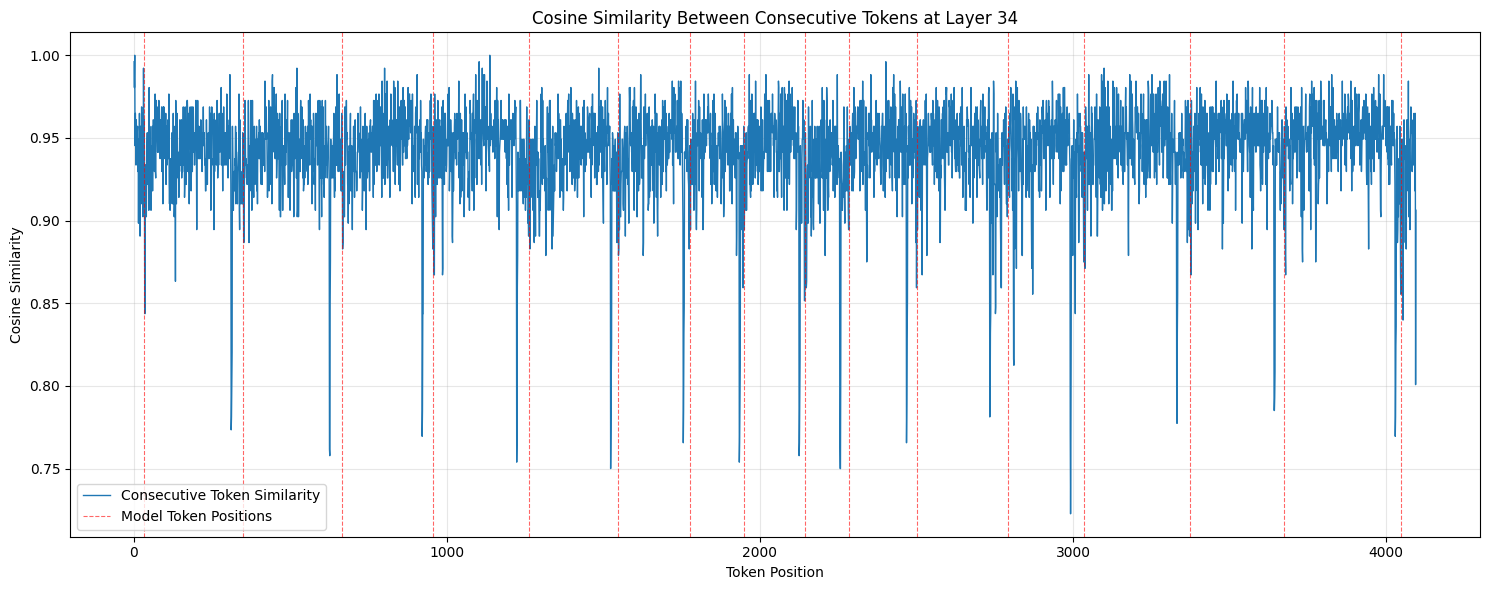

Number of token comparisons: 4095
Mean similarity: 0.9411
Min similarity: 0.7227
Max similarity: 1.0000


In [24]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

layer = 34
# Calculate cosine similarity between each token and the previous one at layer 34
def calculate_consecutive_cosine_similarities(activations, layer):
    """
    Calculate cosine similarity between each token and the previous one at a specific layer.
    
    Args:
        activations: Tensor of shape (n_layers, n_tokens, hidden_dims)
        layer: Layer index to analyze
    
    Returns:
        List[float]: Cosine similarities between consecutive tokens (starting from token 1)
    """
    layer_acts = activations[layer]  # Shape: (n_tokens, hidden_dims)
    similarities = []
    
    # Start from token 1 (compare with token 0)
    for i in range(1, layer_acts.shape[0]):
        current_token = layer_acts[i]
        previous_token = layer_acts[i-1]
        
        sim = F.cosine_similarity(current_token, previous_token, dim=0)
        similarities.append(sim.item())
    
    return similarities

# Calculate consecutive token similarities
consecutive_similarities = calculate_consecutive_cosine_similarities(full_activations, layer)

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(range(1, len(consecutive_similarities) + 1), consecutive_similarities, linewidth=1)
plt.title(f'Cosine Similarity Between Consecutive Tokens at Layer {layer}')
plt.xlabel('Token Position')
plt.ylabel('Cosine Similarity')
plt.grid(True, alpha=0.3)

# Add vertical lines at model token positions for reference
for pos in model_token_indices:
    if pos > 0:  # Only plot if not the first token
        plt.axvline(x=pos, color='red', linestyle='--', alpha=0.6, linewidth=0.8)

plt.legend(['Consecutive Token Similarity', 'Model Token Positions'])
plt.tight_layout()
plt.show()

print(f"Number of token comparisons: {len(consecutive_similarities)}")
print(f"Mean similarity: {sum(consecutive_similarities) / len(consecutive_similarities):.4f}")
print(f"Min similarity: {min(consecutive_similarities):.4f}")
print(f"Max similarity: {max(consecutive_similarities):.4f}")